In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, MinMaxScaler, PowerTransformer,StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
import math

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_test['SalePrice'] = -1
all_data = pd.concat([data_train,data_test]).reset_index()
all_data['Type'] = all_data.apply(lambda x: 'train' if x['SalePrice'] > -1 else 'test',axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          198 non-null    object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [3]:
# Cleaning
# Primero rellenamos con 'NA' aquellos valores vacíos que no lo son en realidad
NA_features = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']
all_data[NA_features] = all_data[NA_features].fillna('NA')
# all_data.loc[(all_data.GarageType == 'NA') & (all_data.GarageCars != 0) ,'GarageCars']




In [4]:
# Data_description.txt nos dice que Functional es typical a menos que Deductions estén garantizadas/justificadas
all_data[['Functional']] = all_data[['Functional']].fillna('Typ')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [5]:
# GarageCars / GarageArea
garage_features = ['Id','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond','Type']
# El registro con Id 2577 parece no tener Garaje, a pesar de que en su GarageType pone Detchd
# Cambiamos ese valor por NA
all_data.loc[all_data.Id == 2577,'GarageType'] = 'NA'
all_data.loc[(all_data.GarageType != 'NA') & (all_data.GarageYrBlt.isnull()) ,garage_features]



,Id,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,Type
2126,2127,Detchd,NaN,NA,1.0,360.0,NA,NA,test


El registro Id 2127 nos da información contradictoria. Por un lado nos dice que tiene un Garaje tipo Detchd en el que cabe 1 coche y por otro nos dice que no tiene según Finish Qual y Cond.
Tenemos que tomar la decisión de cuál es la info correcta. Optamos por dar por válido el hecho de que tiene garaje. 
Para rellenar Finish vemos que la mayoría de los garajes tipo Detchd son 'Unf'
Más concretamente, vemos que para las casas con GarageCars == 1, la combinación más habitual de Finish, Qual y Cond es 'Unf', 'TA', 'TA' (481)
Además debemos rellenar el GarageYrBlt. Usamos la fecha de última remodelación (1983)

In [6]:
all_data.loc[(all_data.GarageCars == 1)].groupby(['GarageFinish','GarageQual','GarageCond']).count()
all_data.loc[(all_data.GarageCars == 1) & (all_data.GarageFinish == 'Unf') & (all_data.GarageQual == 'TA') & (all_data.GarageCond == 'TA')]
all_data.loc[all_data.Id == 2127,['GarageFinish','GarageQual','GarageCond']] = ['Unf','TA','TA']
all_data.loc[all_data.Id == 2127,['GarageYrBlt']] = all_data.loc[(all_data.Id == 2127),'YearRemodAdd'].values
all_data.loc[(all_data.GarageType != 'NA') & (all_data.GarageYrBlt.isnull()) ,garage_features]
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [7]:
# Rellenamos los nulos de Cars y Area con cero puesto que es un registro que no tiene garaje
all_data[['GarageCars','GarageArea']] = all_data[['GarageCars','GarageArea']].fillna(0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [8]:

# Nos aseguramos de que sólo los que no tienen garaje no tienen informada la fecha de construcción del garaje
all_data.loc[(all_data.GarageYrBlt.isnull()),garage_features] # 158
all_data.loc[all_data.GarageType == 'NA'] #158
all_data.loc[all_data.GarageType == 'NA'].groupby(['GarageType','GarageQual']).count() # 158
all_data.loc[all_data.GarageType == 'NA'].groupby(['GarageType','GarageQual','GarageCond']).count() # 158
all_data.groupby(['GarageType','GarageQual','GarageCond']).count() # 158

index    Id  MSSubClass  MSZoning  \
GarageType GarageQual GarageCond                                      
2Types     Fa         Fa              1     1           1         1   
                      TA              1     1           1         1   
           TA         TA             21    21          21        21   
Attchd     Fa         Fa              1     1           1         1   
                      Po              1     1           1         0   
                      TA             14    14          14        13   
           Gd         Gd              6     6           6         6   
                      TA             11    11          11        11   
           TA         Fa              4     4           4         4   
                      Gd              6     6           6         6   
                      Po              1     1           1         1   
                      TA           1679  1679        1679      1679   
Basment    Fa         TA              4     4           4         4   
           Gd         TA              1     1           1         1   
           TA         TA             31    31          31        31   
BuiltIn    Fa         TA              3     3           3         3   
           Gd         TA              1     1           1         1   
           TA         TA            182   182         182       182   
CarPort    Fa         Fa              1     1           1         1   
                      TA              1     1           1         1   
           TA         TA             13    13          13        13   
Detchd     Ex         Ex              2     2           2         2   
                      TA              1     1           1         1   
           Fa         Fa             36    36          36        36   
                      Po              7     7           7         7   
                      TA             54    54          54        54   
           Gd         Ex              1     1           1         1   
                      TA              4     4           4         4   
           Po         Fa              1     1           1         1   
                      Po              4     4           4         4   
           TA         Fa             30    30          30        29   
                      Gd              3     3           3         3   
                      Po              1     1           1         1   
                      TA            634   634         634       633   
NA         NA         NA            158   158         158       158   

                                  LotFrontage  LotArea  Street  Alley  \
GarageType GarageQual GarageCond                                        
2Types     Fa         Fa                    1        1       1      1   
                      TA                    0        1       1      1   
           TA         TA                   17       21      21     21   
Attchd     Fa         Fa                    1        1       1      1   
                      Po                    1        1       1      1   
                      TA                   13       14      14     14   
           Gd         Gd                    4        6       6      6   
                      TA                   10       11      11     11   
           TA         Fa                    4        4       4      4   
                      Gd                    2        6       6      6   
                      Po                    1        1       1      1   
                      TA                 1357     1679    1679   1679   
Basment    Fa         TA                    3        4       4      4   
           Gd         TA                    0        1       1      1   
           TA         TA                   23       31      31     31   
BuiltIn    Fa         TA                    2        3       3      3   
           Gd         TA                    1        1       1      1   
           TA      

In [9]:
# Rellenamos la fecha de construcción del garaje con 0
all_data[['GarageYrBlt']] = all_data[['GarageYrBlt']].fillna(0)

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [11]:
# Basement Cleaning
bsmt_features = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
all_data.loc[(all_data.BsmtFinSF1.isnull()) | (all_data.BsmtFinSF2.isnull())| (all_data.BsmtUnfSF.isnull())| (all_data.TotalBsmtSF.isnull()),bsmt_features]
all_data[bsmt_features] = all_data[bsmt_features].fillna(0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [12]:
all_data.loc[(all_data.BsmtQual != 'NA') & (all_data.BsmtFinSF1 == 0) & (all_data.BsmtFinSF2 == 0) & (all_data.BsmtUnfSF == 0), bsmt_features ]
all_data.loc[(all_data.BsmtFinType1 != 'NA') & (all_data.BsmtFinType1 != 'Unf') & (all_data.BsmtFinSF1 == 0), bsmt_features ]
all_data.loc[(all_data.BsmtFinType2 != 'NA') & (all_data.BsmtFinType2 != 'Unf') & (all_data.BsmtFinSF2 == 0), bsmt_features ]
# all_data.loc[((all_data.BsmtFinType2 == 'NA') | (all_data.BsmtFinType2 == 'Unf')) & (all_data.BsmtFinSF2 == 0), bsmt_features ]
all_data.loc[(all_data.BsmtFinSF2 == 0), bsmt_features ].groupby('BsmtFinType2').count()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
BsmtFinType2,,,,,,,,
BLQ,1,1,1,1,1,1,1,1
NA,79,79,79,79,79,79,79,79
Unf,2492,2492,2492,2492,2492,2492,2492,2492


In [13]:
# Parece que existe un error en el Id 1471. BsmtFinType2 indica BLQ pero BsmtFinSF2 nos dice 0.0. Podría suceder que BsmtFinType2 = 'Unf'
# Sustituimos por 'Unf'
all_data.loc[all_data.Id == 1471, 'BsmtFinType2'] = 'Unf'
all_data.loc[(all_data.BsmtFinSF2 == 0), bsmt_features ].groupby('BsmtFinType2').count()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
BsmtFinType2,,,,,,,,
NA,79,79,79,79,79,79,79,79
Unf,2493,2493,2493,2493,2493,2493,2493,2493


In [14]:
all_data.loc[all_data.BsmtFinSF1 + all_data.BsmtFinSF2 + all_data.BsmtUnfSF != all_data.TotalBsmtSF,bsmt_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [15]:
# Basement Baths
bath_features = bsmt_features + ['BsmtFullBath','BsmtHalfBath']
all_data[['BsmtFullBath','BsmtHalfBath']] = all_data[['BsmtFullBath','BsmtHalfBath']].fillna(0)
all_data.loc[(all_data.BsmtFullBath.isnull()) | (all_data.BsmtHalfBath.isnull()) , bath_features]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath


In [16]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [17]:
# SaleType Cleaning
sale_features = ['MoSold','YrSold','SaleType','SaleCondition']
all_data.loc[all_data.SaleType.isnull(), sale_features]
all_data.loc[all_data.SaleCondition == 'Normal',sale_features].groupby(['SaleType','SaleCondition']).count()
all_data[['SaleType']] = all_data[['SaleType']].fillna('WD')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [18]:
# Kitche Quality Id 1556
# Rellenamos nulos con TA que parece ser el más habitual en las casas con el mismo OverallQual
kit_features = ['KitchenAbvGr','KitchenQual','OverallQual','Id']
all_data.loc[(all_data.OverallQual == 5) & (all_data.YearRemodAdd <= 1953), kit_features].groupby(['KitchenAbvGr','KitchenQual','OverallQual']).count()
# all_data.loc[(all_data.OverallQual == 10) , kit_features].groupby(['KitchenAbvGr','KitchenQual','OverallQual']).count()
all_data[['KitchenQual']] = all_data[['KitchenQual']].fillna('TA')
all_data.loc[all_data.KitchenQual.isnull(), kit_features]

,KitchenAbvGr,KitchenQual,OverallQual,Id


In [19]:
all_data.loc[all_data.Electrical.isnull(),['YearBuilt']]
all_data.loc[all_data.YearBuilt >= 2006].groupby('Electrical').count()
all_data.groupby('Electrical').count()
all_data[['Electrical']] = all_data[['Electrical']].fillna('SBrkr')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2919 non-null   int64  
 1   Id             2919 non-null   int64  
 2   MSSubClass     2919 non-null   int64  
 3   MSZoning       2915 non-null   object 
 4   LotFrontage    2433 non-null   float64
 5   LotArea        2919 non-null   int64  
 6   Street         2919 non-null   object 
 7   Alley          2919 non-null   object 
 8   LotShape       2919 non-null   object 
 9   LandContour    2919 non-null   object 
 10  Utilities      2917 non-null   object 
 11  LotConfig      2919 non-null   object 
 12  LandSlope      2919 non-null   object 
 13  Neighborhood   2919 non-null   object 
 14  Condition1     2919 non-null   object 
 15  Condition2     2919 non-null   object 
 16  BldgType       2919 non-null   object 
 17  HouseStyle     2919 non-null   object 
 18  OverallQ

In [20]:
ext_features = ['Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','UniqueExterior']
all_data[['Exterior2nd']] = all_data.apply(lambda x: 'WdShing' if x['Exterior2nd'] == 'Wd Shng' else x['Exterior2nd'],axis=1)
all_data[['Exterior2nd']] = all_data.apply(lambda x: 'CemntBd' if x['Exterior2nd'] == 'CmentBd' else x['Exterior2nd'],axis=1)
all_data[['Exterior2nd']] = all_data.apply(lambda x: 'BrkComm' if x['Exterior2nd'] == 'Brk Cmn' else x['Exterior2nd'],axis=1)
all_data['UniqueExterior'] = all_data.apply(lambda x: 1 if x['Exterior1st'] == x['Exterior2nd'] else 0,axis=1)

all_data.loc[(all_data.Exterior1st.isnull()) | (all_data.Exterior2nd.isnull()),['Exterior1st','Exterior2nd','OverallQual']]
all_data.loc[all_data.OverallQual == 5, ext_features].groupby(['Exterior1st','Exterior2nd']).count()
# La combinación MetalSd,MetalSd es la más habitual
all_data[['Exterior1st','Exterior2nd']] = all_data[['Exterior1st','Exterior2nd']].fillna('MetalSd')

In [21]:


all_data.loc[all_data.MasVnrType.isnull() == False,ext_features].groupby(['UniqueExterior','MasVnrType']).count() #.sort_values('MasVnrArea',ascending=False).head(50)
all_data.loc[(all_data.UniqueExterior == 1) & (all_data.MasVnrType.isnull()),['MasVnrType']] = all_data.loc[(all_data.UniqueExterior == 1) & (all_data.MasVnrType.isnull()),['MasVnrType']].fillna('None')
all_data.loc[all_data.MasVnrType.isnull(),ext_features]
# set(all_data['Exterior2nd'].unique()).symmetric_difference(set(all_data['Exterior1st'].unique()))

,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,UniqueExterior
529,Wd Sdng,Stone,NaN,NaN,Gd,TA,0


In [22]:
all_data.loc[(all_data.Exterior1st == 'Wd Sdng') & (all_data.Exterior2nd == 'Stone'),['MasVnrType']] = all_data.loc[(all_data.Exterior1st == 'Wd Sdng') & (all_data.Exterior2nd == 'Stone'),['MasVnrType']].fillna('None')


In [23]:
all_data[['MasVnrArea']] =all_data[['MasVnrArea']].fillna(0)

In [24]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           2919 non-null   int64  
 1   Id              2919 non-null   int64  
 2   MSSubClass      2919 non-null   int64  
 3   MSZoning        2915 non-null   object 
 4   LotFrontage     2433 non-null   float64
 5   LotArea         2919 non-null   int64  
 6   Street          2919 non-null   object 
 7   Alley           2919 non-null   object 
 8   LotShape        2919 non-null   object 
 9   LandContour     2919 non-null   object 
 10  Utilities       2917 non-null   object 
 11  LotConfig       2919 non-null   object 
 12  LandSlope       2919 non-null   object 
 13  Neighborhood    2919 non-null   object 
 14  Condition1      2919 non-null   object 
 15  Condition2      2919 non-null   object 
 16  BldgType        2919 non-null   object 
 17  HouseStyle      2919 non-null   o

In [25]:
# Utilities Cleaning
all_data.loc[all_data.Utilities.isnull(), ['Utilities','Electrical','YearBuilt','YearRemodAdd']]
all_data[['Utilities']] = all_data[['Utilities']].fillna('AllPub')

In [26]:
all_data.loc[all_data.Street == 'Grvl'].groupby('MSZoning',).count()
all_data.loc[all_data.Street == 'Pave'].groupby('MSZoning',).count()
# all_data.loc[all_data.MSZoning.isnull()]
# all_data['MSZoning'].unique()
all_data.loc[all_data.Street == 'Grvl', ['MSZoning']] = all_data.loc[all_data.Street == 'Grvl', ['MSZoning']].fillna('C (all)')
all_data.loc[all_data.Street != 'Grvl', ['MSZoning']] = all_data.loc[all_data.Street != 'Grvl', ['MSZoning']].fillna('RL')

In [27]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 84 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           2919 non-null   int64  
 1   Id              2919 non-null   int64  
 2   MSSubClass      2919 non-null   int64  
 3   MSZoning        2919 non-null   object 
 4   LotFrontage     2433 non-null   float64
 5   LotArea         2919 non-null   int64  
 6   Street          2919 non-null   object 
 7   Alley           2919 non-null   object 
 8   LotShape        2919 non-null   object 
 9   LandContour     2919 non-null   object 
 10  Utilities       2919 non-null   object 
 11  LotConfig       2919 non-null   object 
 12  LandSlope       2919 non-null   object 
 13  Neighborhood    2919 non-null   object 
 14  Condition1      2919 non-null   object 
 15  Condition2      2919 non-null   object 
 16  BldgType        2919 non-null   object 
 17  HouseStyle      2919 non-null   o

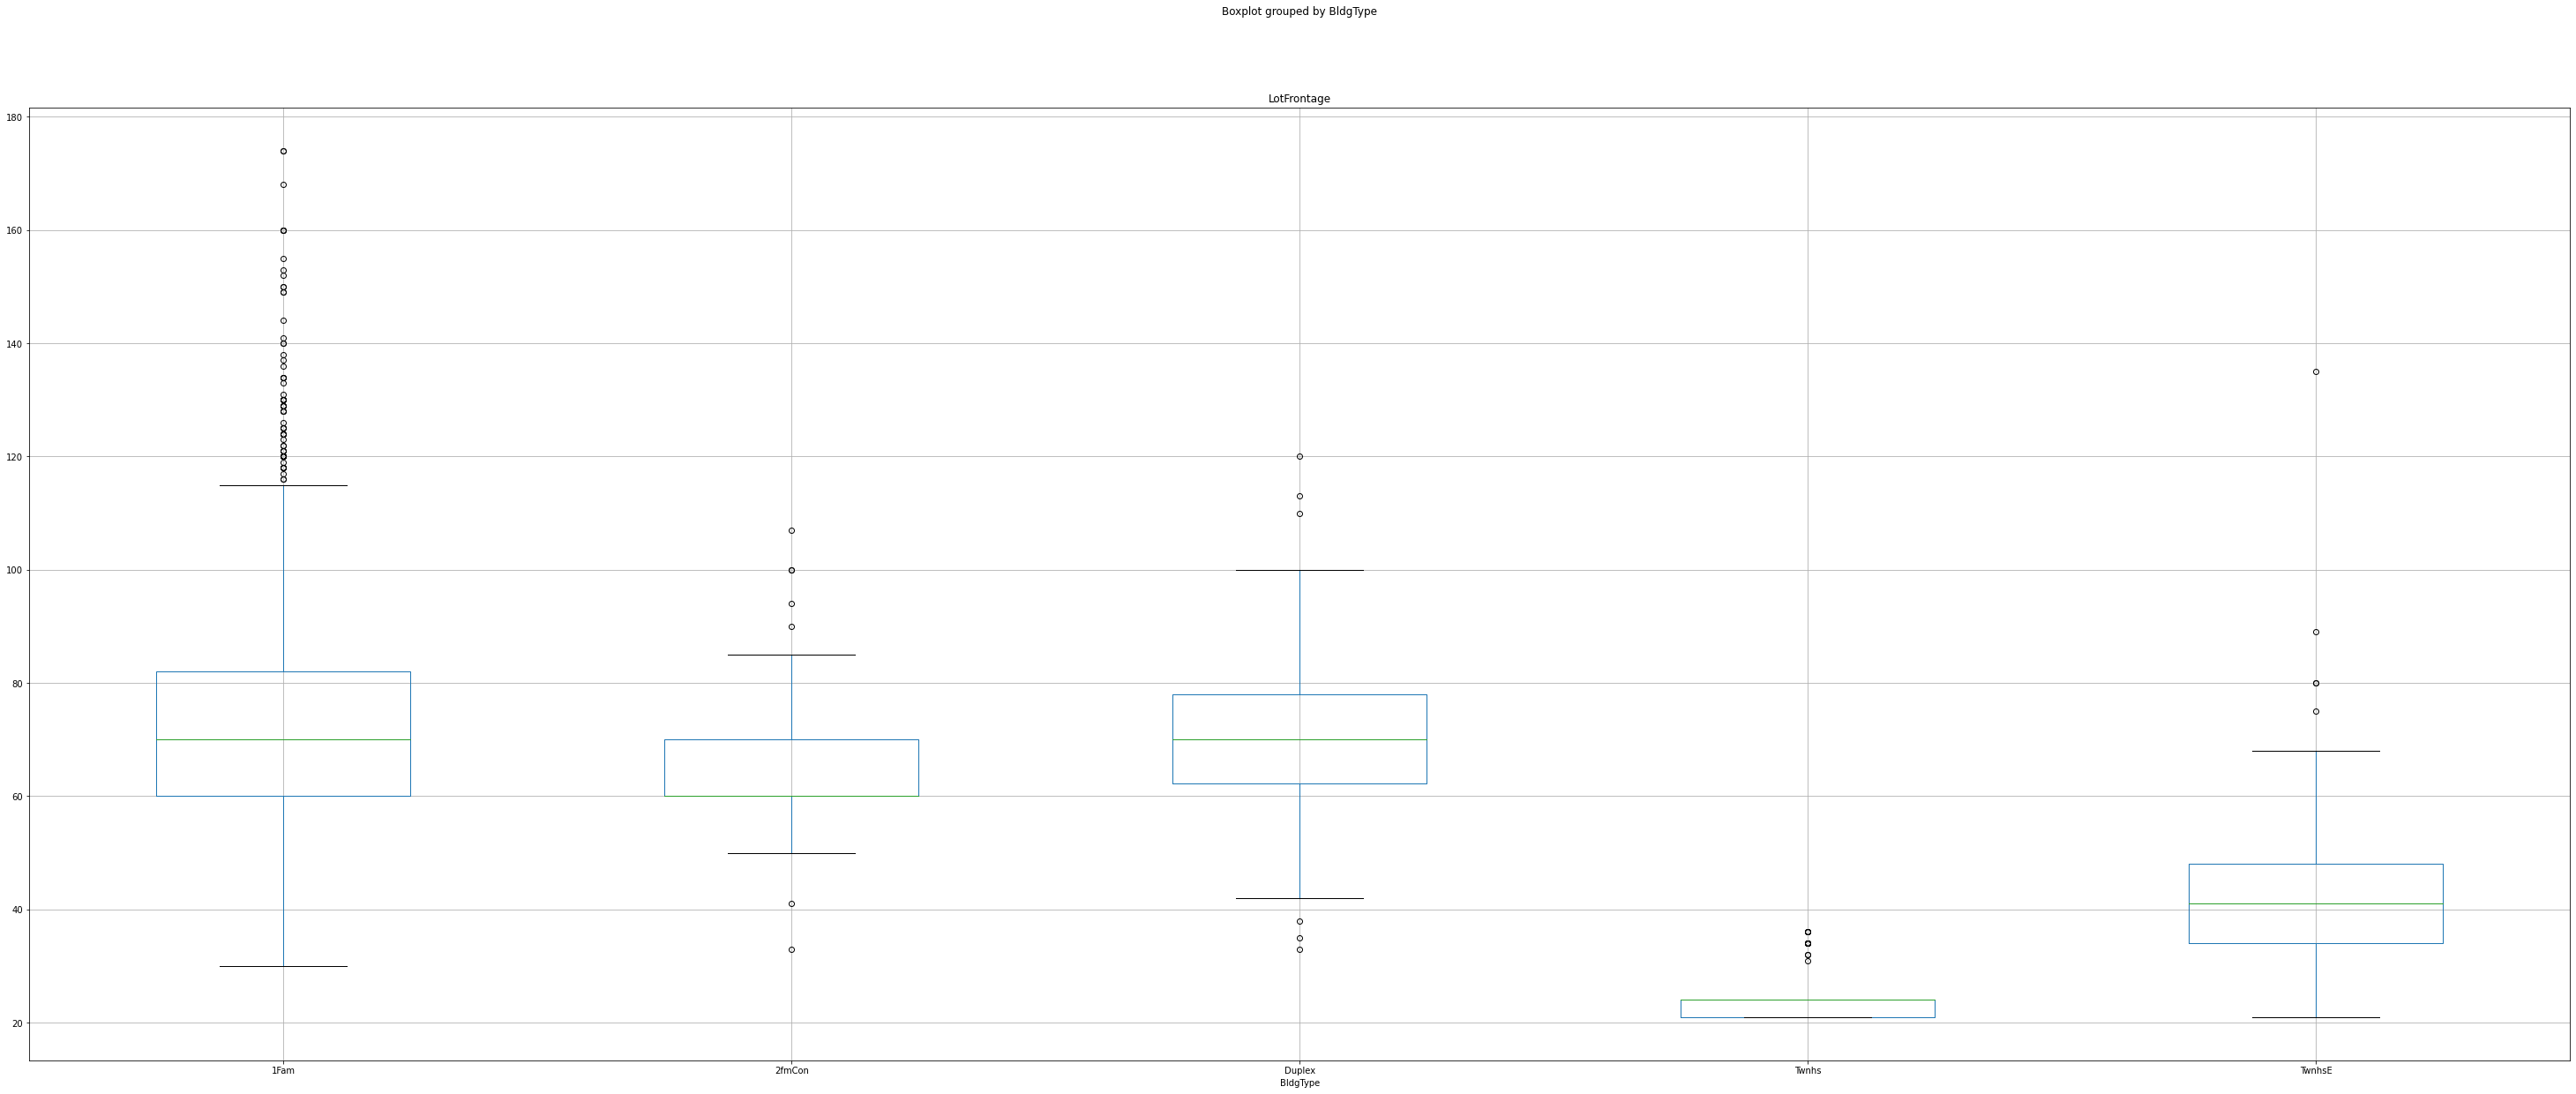

In [28]:
all_data['LotFrontage'] = all_data.apply(lambda x: np.nan if x['LotFrontage'] > 180 else x['LotFrontage'], axis=1)
all_data.boxplot(column='LotFrontage',by='BldgType',figsize=(50,20))

In [29]:
from custom_functions import get_resume, information_gain
all_data[['LotFrontage']].var()
gains = []
for x in all_data.columns:
    if x != 'LotFrontage' and pd.api.types.is_object_dtype(all_data[x].dtype):
        gains.append((x,information_gain(all_data,'LotFrontage',x,norm=True)))
# print(gains)
gains.sort(key=lambda x: x[1], reverse = True)
gains
# print("Information gain: {}".format(information_gain(all_data,'LotFrontage','BldgType', norm=True)))
# get_resume(all_data,"LotFrontage",'BldgTypeNeighborhood')

lf_means = all_data[['LotFrontage','BldgType']].groupby('BldgType').mean().to_dict()
all_data['LotFrontage'] = all_data.apply(lambda x: lf_means['LotFrontage'][x['BldgType']] if math.isnan(x['LotFrontage']) else x['LotFrontage'], axis=1)
#  all_data[['LotFrontage']] = all_data[['LotFrontage']].fillna(all_data['LotFrontage'].mean())
gains

[('BldgType', 0.43),
 ('Neighborhood', 0.41),
 ('MSZoning', 0.29),
 ('GarageType', 0.25),
 ('LotConfig', 0.23),
 ('Exterior2nd', 0.23),
 ('FireplaceQu', 0.22),
 ('GarageFinish', 0.22),
 ('BsmtQual', 0.21),
 ('Alley', 0.2),
 ('RoofStyle', 0.2),
 ('Exterior1st', 0.2),
 ('MasVnrType', 0.2),
 ('ExterQual', 0.2),
 ('KitchenQual', 0.2),
 ('LotShape', 0.19),
 ('HouseStyle', 0.19),
 ('BsmtExposure', 0.19),
 ('Condition1', 0.18),
 ('Foundation', 0.18),
 ('HeatingQC', 0.18),
 ('GarageQual', 0.18),
 ('GarageCond', 0.18),
 ('PoolQC', 0.18),
 ('SaleType', 0.18),
 ('SaleCondition', 0.18),
 ('Street', 0.17),
 ('LandContour', 0.17),
 ('Utilities', 0.17),
 ('LandSlope', 0.17),
 ('Condition2', 0.17),
 ('RoofMatl', 0.17),
 ('ExterCond', 0.17),
 ('BsmtCond', 0.17),
 ('BsmtFinType1', 0.17),
 ('BsmtFinType2', 0.17),
 ('Heating', 0.17),
 ('CentralAir', 0.17),
 ('Electrical', 0.17),
 ('Functional', 0.17),
 ('PavedDrive', 0.17),
 ('Fence', 0.17),
 ('MiscFeature', 0.17),
 ('Type', 0.17)]

In [30]:
# Existen outliers de LotArea por encima de 100000 en train, eliminamos estos registros
# all_data.loc[all_data.LotArea > 100000,:]

In [31]:
# New Features
all_data['LotAreaNorm'] = np.log(all_data.LotArea + 1)
all_data['FireplacesNorm'] = np.log(all_data.Fireplaces + 1)
all_data['OpenPorchSFNorm'] = np.log(all_data.OpenPorchSF + 1)
all_data["BsmtFinType1BsmtFinType2"] = all_data["BsmtFinType1"]+all_data["BsmtFinType2"]
all_data["HeatingHeatingQC"] = all_data["Heating"] + all_data["HeatingQC"]
all_data["1stFlrSF2ndFlrSF"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]
all_data["TotalBaths"] = all_data["HalfBath"] + all_data["FullBath"] + all_data["BsmtHalfBath"] + all_data["BsmtFullBath"]
all_data['OverallQualOverallCond'] = all_data['OverallQual'] * all_data['OverallCond']
tags = ['Po','Fa','TA','Gd','Ex']
all_data['ExterQualExterCond'] = all_data.apply(lambda x: (tags.index(x['ExterQual'])+1)*(tags.index(x['ExterCond'])+1),axis=1)
all_data['LotDepth'] = all_data['LotArea'] / all_data['LotFrontage']
# columns_dict = {}
# treatments = []
# for x in all_data.columns:
#     if pd.api.types.is_numeric_dtype(all_data[x].dtype):
#         treatments.append('num')
#     else:
#         treatments.append('cat')
# columns_dict = {'feature':all_data.columns, 'treatment':treatments}
# columns_df = pd.DataFrame(columns_dict)
# columns_df['good'] = 0
# columns_df['bad'] = 0
# columns_df.to_csv('columns_df.csv')

In [32]:
columns_df = pd.read_csv('columns_df.csv', index_col = 'index')
drop_features = columns_df.loc[columns_df.treatment == 'drop','feature'].unique()
cat_features = columns_df.loc[columns_df.treatment == 'cat','feature'].unique()
num_features = columns_df.loc[columns_df.treatment == 'num','feature'].unique()
pass_features = columns_df.loc[columns_df.treatment == 'pass','feature'].unique()
cat_features

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'BsmtFinType1BsmtFinType2',
       'HeatingHeatingQC'], dtype=object)

In [33]:
all_data['Type'] = all_data.apply(lambda x: 0 if x['Type'] == 'train' or x['Type'] == 0 else 1,axis=1)
num_pipeline = Pipeline([
    ("1",RobustScaler()),
    ("2",PowerTransformer()),
    ("3",MinMaxScaler()),
])
passing = all_data[pass_features]
all_data_dropped = all_data.drop(pass_features,axis=1)
transform1 = ColumnTransformer([    
    # ('pass','passthrough',pass_features),
    ('num','passthrough',num_features),
    ('cat',OneHotEncoder(sparse=False),cat_features)    
])

full_pipeline = Pipeline([
    ('prev',transform1),
    ('full',num_pipeline)
])

all_data_prep_array = full_pipeline.fit_transform(all_data_dropped)
ohe_features = transform1.named_transformers_['cat'].get_feature_names()

all_features = np.concatenate([num_features,ohe_features])
all_data_prep = pd.DataFrame(all_data_prep_array,columns = all_features)
# all_features = np.concatenate([pass_features,num_features,cat_features])
all_data_prep = pd.DataFrame(all_data_prep_array,columns = all_features)
all_data_prep['Type'] = all_data['Type']
all_data_prep['SalePrice'] = all_data['SalePrice']
all_data_prep

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,x45_GasWFa,x45_GasWGd,x45_GasWTA,x45_GravFa,x45_OthWFa,x45_WallFa,x45_WallPo,x45_WallTA,Type,SalePrice
0,0.277663,0.908224,0.794561,0.802171,0.397321,0.0,0.147141,0.239518,0.313415,0.806743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,208500
1,0.306006,0.608653,0.275813,0.000000,0.482012,0.0,0.262442,0.328561,0.471700,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,181500
2,0.338807,0.883032,0.767859,0.756480,0.309432,0.0,0.372905,0.254798,0.343578,0.810635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,223500
3,0.304880,0.195388,0.200231,0.000000,0.160876,0.0,0.438930,0.214748,0.361879,0.771833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,140000
4,0.384743,0.870610,0.716416,0.907828,0.378828,0.0,0.408978,0.304646,0.433784,0.862650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0.031128,0.554557,0.200231,0.000000,0.000000,0.0,0.442395,0.159583,0.141191,0.672423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1
2915,0.029108,0.554557,0.200231,0.000000,0.183989,0.0,0.270424,0.159583,0.141191,0.672423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1
2916,0.448061,0.473628,0.621293,0.000000,0.543813,0.0,0.000000,0.320917,0.459917,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1
2917,0.323671,0.775471,0.536367,0.000000,0.234416,0.0,0.458785,0.252914,0.365787,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-1


In [34]:
train = all_data_prep.loc[all_data_prep.Type <= 0,:]
test = all_data_prep.loc[all_data_prep.Type >= 1,:]
test_prepared = test.drop(['SalePrice','Type'],axis=1)
X = train.drop(['SalePrice','Type'],axis=1)
y = train['SalePrice']

In [35]:
corr_columns = train.corr().sort_values(by='SalePrice',ascending = False).reset_index()['index']
corr_columns.drop(0, inplace= True)
corr_columns

1      1stFlrSF2ndFlrSF
2             GrLivArea
3            GarageCars
4            GarageArea
5            TotalBaths
             ...       
360              x19_TA
361              x0_150
362          x44_RecGLQ
363          x45_WallPo
364                Type
Name: index, Length: 364, dtype: object

In [37]:
# clf = SVR(C=100400 ,degree=2,epsilon=2500, kernel='poly')
clf = XGBRegressor(objective="reg:squarederror")
# clf = LGBMRegressor()
# # cross_val_score(clf,X.values,y,scoring='neg_mean_squared_log_error', cv=10,verbose=1)
# clf.fit(X,y)
# feature_importance = pd.DataFrame({"feature": X.columns, "importance":map(lambda x: round(x,4),clf.feature_importances_)}).sort_values(by='importance',ascending=False)
# feature_importance
# lr_clf = LinearRegression()
# params = [{"max_depth":[3,6,7,10,60],"lambda":[1,1.5,2],"estimators":[20,30,100,300,600],"gamma":[0,0.01,0.03,0.1] }]
# params = [{"C":[10,30,60,100,600,1000100,1000000],"degree":[1,2,3,4,5]}]
# params = [{"max_depth":[3,6,10,60,100,500,-1],"learning_rate":[0.01,0.05,0,1],"estimators":[20,30,100,300,600],"num_leaves":[15,31,63,127] }]
# grid = GridSearchCV(clf,params,scoring="neg_mean_squared_log_error", cv=8, verbose=1,n_jobs=-1)
# grid.fit(X,y)
# clf_best = grid.best_estimator_
# print("Best:", grid.best_params_)
print(math.sqrt(-1*cross_val_score(clf,X,y,cv=6,n_jobs=-1,scoring='neg_mean_squared_log_error').mean()))

0.13124283573833248


In [38]:
# Analizamos XGBoost
clf = XGBRegressor(objective="reg:squarederror",n_jobs=-1)
params = [{"max_depth":[3,5,7],"estimators":[2000], "lambda":[1,1.5,2], "min_child_weight":[1,1.5]}]
params = [
    {
        "n_estimators": np.logspace(0.5,4,8,dtype=np.int32),
        "max_depth" : [1,2,3,4],
        "max_delta_step": np.linspace(0,20,4),
        "min_child_weight":[1,1.5]
    }
]
grid = GridSearchCV(clf,params,scoring="neg_mean_squared_log_error", cv=6, verbose=10,n_jobs=-1,return_train_score=True)
grid.fit(X,y)
clf_best1 = grid.best_estimator_
print("Best1: {} | Error: {}".format(grid.best_params_, math.sqrt(-1*grid.best_score_.mean())))
results = pd.DataFrame(grid.cv_results_)
results[['param_n_estimators','param_max_depth','param_max_delta_step','param_min_child_weight','mean_train_score','std_train_score','mean_test_score','std_test_score']].sort_values(by='mean_test_score',ascending=False).head(50)

Fitting 6 folds for each of 256 candidates, totalling 1536 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0839s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1429s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  1.5min
[Parallel(n

,param_n_estimators,param_max_depth,param_max_delta_step,param_min_child_weight,mean_train_score,std_train_score,mean_test_score,std_test_score
21,1000,2,0,1,-2.831795e-03,1.751896e-04,-0.015376,0.004220
29,1000,2,0,1.5,-2.767038e-03,2.136268e-04,-0.015398,0.003537
37,1000,3,0,1,-5.177782e-04,3.819686e-05,-0.015411,0.003896
22,3162,2,0,1,-4.382161e-04,2.053979e-05,-0.015450,0.004079
61,1000,4,0,1.5,-4.570778e-05,3.365130e-06,-0.015486,0.004066
62,3162,4,0,1.5,-1.436189e-07,2.880478e-07,-0.015489,0.004028
63,10000,4,0,1.5,-2.130123e-08,4.761559e-08,-0.015492,0.004028
60,316,4,0,1.5,-1.269133e-03,6.685684e-05,-0.015493,0.004153
38,3162,3,0,1,-6.890306e-06,6.503673e-07,-0.015495,0.003744
39,10000,3,0,1,-1.889169e-10,6.409746e-11,-0.015506,0.003729


In [48]:
# Analizamos LightGBM
clf_lgbm = LGBMRegressor(n_jobs=-1,random_state=42,)
params = [
    {
        "n_estimators": np.logspace(0.5,4,6,dtype=np.int32),
        "max_depth" : np.logspace(0,2,4,dtype=np.int32),
        "min_child_samples":np.linspace(1,20,4,dtype=np.int32)
    }
]
grid = GridSearchCV(clf_lgbm,params,scoring="neg_mean_squared_log_error", cv=6, verbose=10,n_jobs=-1,return_train_score=True)
grid.fit(X,y)
clf_lgbm_best1 = grid.best_estimator_
print("Best1: {} | Error: {}".format(grid.best_params_, math.sqrt(-1*grid.best_score_.mean())))
results = pd.DataFrame(grid.cv_results_)
results[['param_n_estimators','param_max_depth','param_min_child_samples','mean_train_score','std_train_score','mean_test_score','std_test_score']].sort_values(by='mean_test_score',ascending=False).head(50)

Fitting 6 folds for each of 96 candidates, totalling 576 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0681s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.1966s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   17.7s
[Parallel(n_j

,param_n_estimators,param_max_depth,param_min_child_samples,mean_train_score,std_train_score,mean_test_score,std_test_score
33,398,4,7,-1.068049e-03,8.485999e-05,-0.016861,0.004052
27,398,4,1,-5.959997e-04,5.363887e-05,-0.016985,0.005036
28,1995,4,1,-2.738126e-07,4.900326e-08,-0.017082,0.004893
29,10000,4,1,-6.437305e-22,1.344194e-22,-0.017083,0.004894
34,1995,4,7,-2.222705e-06,3.787382e-07,-0.017145,0.003915
35,10000,4,7,-3.467295e-13,5.154789e-13,-0.017152,0.003918
45,398,4,20,-3.014620e-03,5.920832e-04,-0.017361,0.003695
39,398,4,13,-1.846248e-03,1.826773e-04,-0.017450,0.003653
32,79,4,7,-6.344009e-03,3.455037e-04,-0.017539,0.004640
26,79,4,1,-4.928366e-03,3.478898e-04,-0.017555,0.005239


In [39]:

clf2 = SVR(kernel='poly')
clf3 = Lasso(normalize=True)
# clf3 = RandomForestRegressor(random_state=42)
# params = [{"max_depth":[3,5,7],"estimators":[3,5,10,20,50], "lambda":[1,1.5,2], "min_child_weight":[0.5,1,1.5]}]

params2 = [{"C":[100090,100420,100030,100040],"epsilon":[10,40,200,500], "degree":[2,3] }]
params3 = [{'max_iter':[600,1000,1500,2000],'alpha':[1,1.5,2,3]}]
# params3 = [{'n_estimators':[1000,2000,3500],"min_samples_split":[2,3,4],"max_depth":[3,10,30,None]}]

grid2 = GridSearchCV(clf2,params2,scoring="neg_mean_squared_log_error", cv=6, verbose=1,n_jobs=-1)
grid2.fit(X,y)
clf_best2 = grid2.best_estimator_
print("Best1: {} | Error: {}".format(grid2.best_params_, math.sqrt(-1*grid2.best_score_.mean())))

# grid3 = GridSearchCV(clf3,params3,scoring="neg_mean_squared_error", cv=6, verbose=1,n_jobs=-1)
# grid3.fit(X,y)
# clf_best3 = grid3.best_estimator_
# print("Best1: {} | Error: {}".format(grid3.best_params_, math.sqrt(-1*grid3.best_score_.mean())))

Fitting 6 folds for each of 32 candidates, totalling 192 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   23.9s finished
Best1: {'C': 100030, 'degree': 2, 'epsilon': 500} | Error: 0.13069190220153257


In [40]:
r = permutation_importance(clf_best1,X, y, n_repeats=20, random_state=42, n_jobs=-1)
feature_importance = pd.DataFrame({"feature": X.columns, "importance":map(lambda x: round(x,4),r.importances_mean)}).sort_values(by='importance',ascending=False)
feature_importance.loc[feature_importance.importance > 0.0015]

,feature,importance
32,1stFlrSF2ndFlrSF,0.1269
34,OverallQualOverallCond,0.0570
1,YearBuilt,0.0348
4,BsmtFinSF1,0.0310
7,TotalBsmtSF,0.0309
0,LotArea,0.0179
17,GarageCars,0.0146
9,2ndFlrSF,0.0113
188,x19_TA,0.0109
11,GrLivArea,0.0099


In [51]:
final_clf = VotingRegressor([('clf1',clf_best1),('clf2',clf_lgbm_best1),('clf3',clf_best2)],n_jobs=-1)
finals = X.columns.values
X_train_finals = X[finals]
error = -1 * cross_val_score(final_clf,X_train_finals.values,y,scoring='neg_mean_squared_log_error', cv=6).mean()
min_error = error    
print("Sqrt Error: {:.10f} | Features: {} | Min Error: {:.10f} | Step: {}: {}/{}".format(math.sqrt(error),X.shape[1],math.sqrt(min_error),'All',0,X.shape[1]))  
removed = []
finals_temp = []
i = 0
for f in feature_importance['feature']:
    removed.append(f)
    X_train_finals = X.drop(removed,axis=1)
    error = -1 * cross_val_score(final_clf,X_train_finals.values,y,scoring='neg_mean_squared_log_error', cv=6).mean()
    if min_error > error:
        min_error = error
    else:        
        removed.remove(f) 
    print("Sqrt Error: {:.10f} | Features: {} | Min Error: {:.10f} | Step: {}: {}/{}".format(math.sqrt(error),X_train_finals.shape[1],math.sqrt(min_error),f,i+1,X.shape[1]))  
    i += 1   


 | Features: 342 | Min Error: 0.1169010651 | Step: x33_NA: 150/363
Sqrt Error: 0.1168991449 | Features: 342 | Min Error: 0.1168991449 | Step: x30_Mix: 151/363
Sqrt Error: 0.1172224437 | Features: 341 | Min Error: 0.1168991449 | Step: x33_Po: 152/363
Sqrt Error: 0.1173925702 | Features: 341 | Min Error: 0.1168991449 | Step: x33_TA: 153/363
Sqrt Error: 0.1168967044 | Features: 341 | Min Error: 0.1168967044 | Step: x30_FuseP: 154/363
Sqrt Error: 0.1169633380 | Features: 340 | Min Error: 0.1168967044 | Step: x34_2Types: 155/363
Sqrt Error: 0.1169186324 | Features: 340 | Min Error: 0.1168967044 | Step: LotAreaNorm: 156/363
Sqrt Error: 0.1169121591 | Features: 340 | Min Error: 0.1168967044 | Step: x30_FuseF: 157/363
Sqrt Error: 0.1170805574 | Features: 340 | Min Error: 0.1168967044 | Step: x34_Basment: 158/363
Sqrt Error: 0.1174494252 | Features: 340 | Min Error: 0.1168967044 | Step: x34_BuiltIn: 159/363
Sqrt Error: 0.1168961392 | Features: 340 | Min Error: 0.1168961392 | Step: x6_NoSeWa: 16

In [52]:
X_final = X.drop(removed,axis=1)
final_clf.fit(X_final,y)
y_pred = final_clf.predict(test_prepared.drop(removed,axis=1))
data_test['SalePrice'] = y_pred
data_test[['Id','SalePrice']].to_csv('result_{:.10f}.csv'.format(math.sqrt(min_error)),index=False)

In [43]:
removed
# # test_prepared[['x0_20','x0_60','x0_120']].head(20)
# # data_test.head(20)
# finals2 = feature_importance.iloc[:,0].unique()
# print(math.sqrt(-1*cross_val_score(clf,X[finals2],y,cv=8,n_jobs=-1,scoring='neg_mean_squared_log_error').mean()))
# clf.fit(X[finals2],y)
# y_pred = clf.predict(test_prepared[finals2])
# data_test['SalePrice'] = y_pred
# data_test[['Id','SalePrice']].to_csv('result4.csv',index=False)

['LotArea',
 'GarageCars',
 '2ndFlrSF',
 'x22_Ex',
 'TotRmsAbvGrd',
 'x9_Crawfor',
 'x42_New',
 'YrSold',
 'x9_ClearCr',
 'x8_Sev',
 'x16_HdBoard',
 'x18_BrkCmn',
 '3SsnPorch',
 'x21_BrkTil',
 'x2_Grvl',
 'x32_Mod',
 'x11_PosN',
 'x19_Gd',
 'x34_Detchd',
 'x17_Stucco',
 'x35_Unf',
 'x15_Tar&Grv',
 'x16_AsbShng',
 'x9_Gilbert',
 'x27_OthW',
 'x36_Ex',
 'x28_Po',
 'x28_TA',
 'x37_Ex',
 'x37_Fa',
 'x28_Ex',
 'x37_Gd',
 'x27_Wall',
 'x37_Po',
 'x0_20',
 'x32_Maj1',
 'x32_Min2',
 'x38_N',
 'x30_Mix',
 'x30_FuseP',
 'x34_2Types',
 'x30_FuseF',
 'x34_BuiltIn',
 'x44_LwQBLQ',
 'x44_RecALQ',
 'x44_LwQUnf',
 'x44_LwQRec',
 'x44_LwQALQ',
 'x44_UnfUnf',
 'x45_GasAPo',
 'x45_GasWEx',
 'x45_GasWFa',
 'x45_GasWTA',
 'x45_GravFa',
 'x45_WallFa',
 'x45_WallPo',
 'x42_COD',
 'x41_TenC',
 'x41_Shed',
 'x41_Gar2',
 'x40_NA',
 'x39_Fa',
 'PoolArea',
 'x43_AdjLand',
 'x43_Alloca',
 'x43_Normal',
 'x44_ALQBLQ',
 'x44_ALQRec',
 'x44_ALQUnf',
 'x44_BLQALQ',
 'x27_Grav',
 'x0_45',
 'x27_GasA',
 'x11_Feedr',
 'x

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN   NaN          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  

[1 rows x 82 columns]
      Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
171  172          20       RL        141.0    31770   Pave   NaN      IR1   

    LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
171         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  
171      5   2010        WD         Normal     215000  

[1 rows x 81 columns]
